# Model Laboratory: XGBoost Walk-Forward Validation

**Objective:** Train and validate a Gradient Boosting Regressor (XGBoost) using a strict temporal split (Walk-Forward Validation).

**Methodology:**
1. **Training Window:** Expanding window (Train on Season $1..N$).
2. **Testing Window:** Next chronological season (Test on Season $N+1$).
3. **Metric:** Mean Absolute Error (MAE) - Optimizing for point accuracy.
4. **Forensics:** Analyze Feature Importance and Residual Distributions.

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- CONFIGURATION ---
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Robust Path Handling
current_path = Path.cwd()
if 'notebooks' in str(current_path).lower():
    BASE_DIR = current_path.parent
else:
    BASE_DIR = current_path
PROCESSED_DIR = BASE_DIR / "data" / "processed"

print(f"Base Directory: {BASE_DIR}")

Base Directory: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine


In [6]:
# 1. Load the Feature Matrix
# ------------------------------------------------------------------------------
print("Loading Feature Matrix...")
try:
    df = pd.read_csv(PROCESSED_DIR / "fpl_features_production.csv")
    print(f"Loaded {len(df):,} rows.")
except FileNotFoundError:
    print("CRITICAL: Production features not found. Run Notebook 02 first.")
    # Stop execution if data missing

Loading Feature Matrix...
Loaded 104,355 rows.


C:\Users\kadmi\AppData\Local\Temp\ipykernel_16444\2569644332.py:5: DtypeWarning: Columns (43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROCESSED_DIR / "fpl_features_production.csv")


In [7]:
# 2. Pre-Processing for Model
# ------------------------------------------------------------------------------
# STRATEGY: Whitelist! Only keep Numerics + Structural Keys.
# This is safer than guessing which columns to drop.

# 1. Define the keys needed for logic (splitting/target)
keys = ['season', 'GW', 'element', 'target_points_next_3']

# 2. Select only numeric features (int/float/bool)
# This automatically strips out names, teams, timestamps, etc.
numeric_df = df.select_dtypes(include=[np.number])

# 3. Construct the final model dataframe
# We take all numeric columns, and ensure our keys are present
# (e.g., 'season' might be a string, so it wouldn't be in numeric_df)
model_cols = numeric_df.columns.tolist()
for k in keys:
    if k not in model_cols and k in df.columns:
        model_cols.append(k)

model_df = df[model_cols].copy()

# Validation
print(f"Model Ready Columns: {model_df.shape[1]}")
print(f"Excluded Columns (Contamination): {list(set(df.columns) - set(model_df.columns))}")

Model Ready Columns: 98
Excluded Columns (Contamination): ['web_name', 'kickoff_time', 'team', 'position', 'name', 'opponent_team_name', 'was_home', 'modified']


In [8]:
# 3. Walk-Forward Validation (The Gold Standard)
# ------------------------------------------------------------------------------
# We train on Season N, Test on Season N+1.
# This mimics the real-world scenario of predicting the "unknown future".

seasons = sorted(df['season'].unique())
print(f"Seasons available: {seasons}")

results = []
feature_importance_list = []

print("\n--- STARTING WALK-FORWARD VALIDATION ---")

for i, test_season in enumerate(seasons[1:]): # Start from 2nd season
    train_seasons = seasons[:i+1]
    
    print(f"\nRound {i+1}: Train on {train_seasons} -> Test on {test_season}")
    
    # Split Data
    X_train = model_df[model_df['season'].isin(train_seasons)].drop(columns=['target_points_next_3', 'season', 'GW', 'element'])
    y_train = model_df[model_df['season'].isin(train_seasons)]['target_points_next_3']
    
    X_test = model_df[model_df['season'] == test_season].drop(columns=['target_points_next_3', 'season', 'GW', 'element'])
    y_test = model_df[model_df['season'] == test_season]['target_points_next_3']
    
    # Validation: Ensure we strictly separate time
    print(f"   Train Size: {len(X_train):,} | Test Size: {len(X_test):,}")
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror', # Minimize MAE
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
    
    # Use last 20% of training data as validation set for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )
    
    # Predict
    preds = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    print(f"   MAE: {mae:.3f} | RMSE: {rmse:.3f}")
    
    results.append({
        'test_season': test_season,
        'MAE': mae,
        'RMSE': rmse
    })
    
    # Store Feature Importance
    fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_,
        'season_fold': test_season
    })
    feature_importance_list.append(fi)

Seasons available: ['2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

--- STARTING WALK-FORWARD VALIDATION ---

Round 1: Train on ['2021-22'] -> Test on 2022-23
   Train Size: 25,447 | Test Size: 26,505
   MAE: 2.278 | RMSE: 4.111

Round 2: Train on ['2021-22', '2022-23'] -> Test on 2023-24
   Train Size: 51,952 | Test Size: 29,407
   MAE: 2.059 | RMSE: 3.973

Round 3: Train on ['2021-22', '2022-23', '2023-24'] -> Test on 2024-25
   Train Size: 81,359 | Test Size: 14,178
   MAE: 2.404 | RMSE: 4.264

Round 4: Train on ['2021-22', '2022-23', '2023-24', '2024-25'] -> Test on 2025-26
   Train Size: 95,537 | Test Size: 8,818
   MAE: 2.589 | RMSE: 4.481


In [9]:
# 4. Results Aggregation
# ------------------------------------------------------------------------------
print("\n--- VALIDATION SUMMARY ---")
results_df = pd.DataFrame(results)
print(results_df)
print(f"\nAverage MAE across seasons: {results_df['MAE'].mean():.3f}")


--- VALIDATION SUMMARY ---
  test_season       MAE      RMSE
0     2022-23  2.278100  4.111110
1     2023-24  2.059385  3.972828
2     2024-25  2.404353  4.264375
3     2025-26  2.588990  4.481318

Average MAE across seasons: 2.333


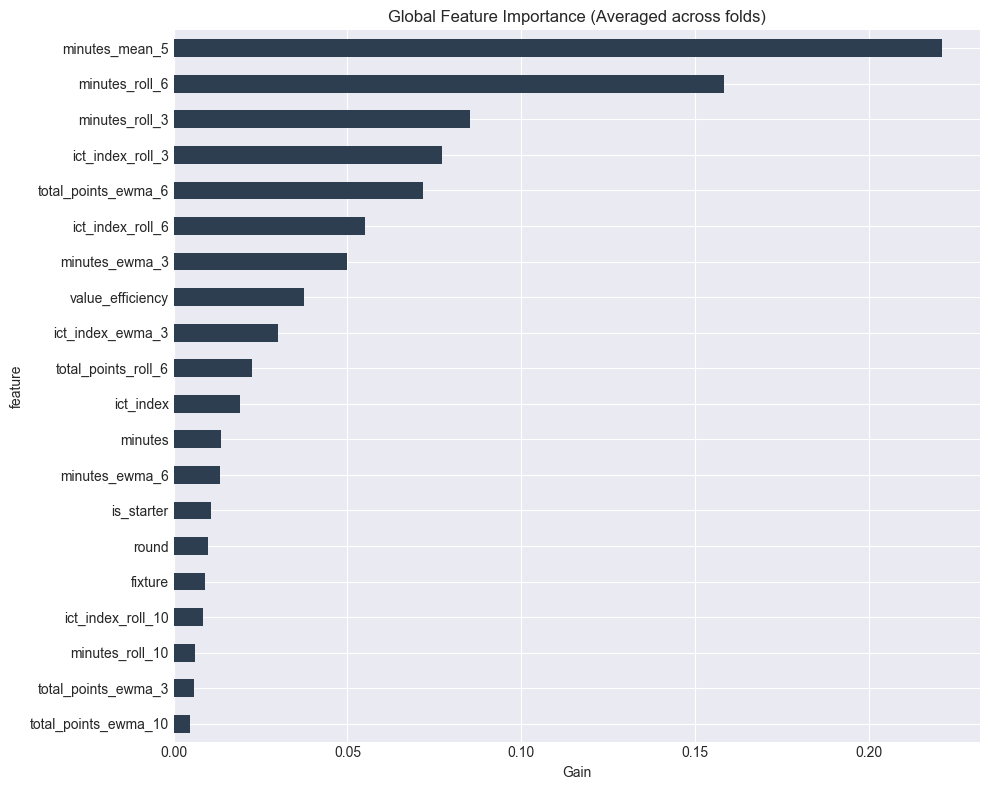

In [10]:
# 5. Global Feature Importance Analysis
# ------------------------------------------------------------------------------
all_fi = pd.concat(feature_importance_list)
avg_fi = all_fi.groupby('feature')['importance'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
avg_fi.plot(kind='barh', color='#2c3e50')
plt.title("Global Feature Importance (Averaged across folds)")
plt.xlabel("Gain")
plt.gca().invert_yaxis() # Top feature at top
plt.tight_layout()
plt.show()

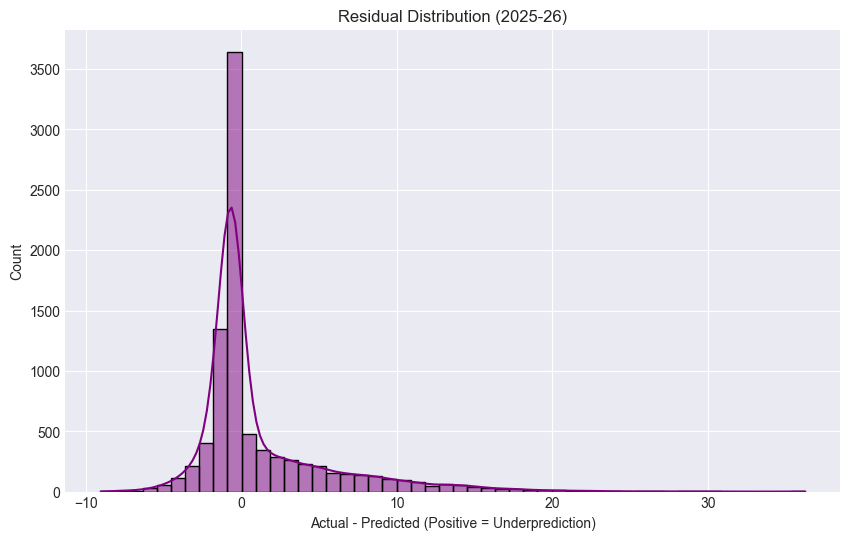

NOTE: Model Lab Complete. Next step: Hyperparameter Tuning or Deployment.


In [11]:
# 6. Error Analysis: Where did we fail?
# ------------------------------------------------------------------------------
# Let's look at the residuals for the last fold
residuals = y_test - preds
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title(f"Residual Distribution ({test_season})")
plt.xlabel("Actual - Predicted (Positive = Underprediction)")
plt.show()

print("NOTE: Model Lab Complete. Next step: Hyperparameter Tuning or Deployment.")